# Agent-Based Model: Cyclist Safety in Amsterdam

This notebook builds an ABM that simulates how cyclist safety changes during a trip through Amsterdam. Using real sensor data from bike-mounted devices, I model how **sudden braking events** cause cyclists to transition between safety states. This is for now a purely **individual project** done by **Marfa Kozelets**. It shows that interesting results can be found following the ABM guidlines used for the my previously completed topic 6 DE assignment. If this plan will be implemented for **tapp_out group project** then **ALL** group members need to understand the core concepts and suggest and **actually implement** at least one point of improvement to the pipeline. 

**RQ** Which areas of Amsterdam exhibit concerning speed patterns and can be considered more dangerous for cyclists?

**GP Relation** This pipeline directly utilises sensor_data collected and layes nicely within the idea of evaluating safety of cycling infrastructure in Amsterdam. 

## Part 1: Model Specification

Before writing any code, I define the key components of my ABM.

### Agents
- **Who are the agnets?** Individual cyclists (group 17 & 18) taking trips through Amsterdam
- **How many?** Each trip is treated as one "agent run" — I have 110 trips in total
- **Agent properties:**
  - state: Current safety state — SAFE (0), AT_RISK (1), or UNSAFE (2)
  - position: Current GPS location (longitude, latitude)
  - breaking events: Count of sudden braking events experienced so far

### Environment
- **What is it?** The Amsterdam road network, represented implicitly through GPS coordinates
- **How do agents interact with it?** As cyclists move through space, certain locations trigger braking events (detected from sensor data)
- **Data source** Real sensor data from bike-mounted devices recording acceleration and GPS location each second

### Rules
1. **Braking Detection** At each timestep, check if acceleration (Acc Y) drops below threshold → braking event detected
2. **State Transition** When a braking event occurs:
   - SAFE → AT_RISK with probability `p_transition`
   - AT_RISK → UNSAFE with probability `p_transition`
3. **No Recovery** Once you transition to a worse state, you stay there (cumulative risk model) (can be changed/evaluated in the future)

### Parameters

**PARAEMETER** braking_threshold; **DESCRIPTION** Acceleration (g) below which counts as sudden braking; **DEFAULT VALUE** -2.0 
**PARAEMETER** p_transition; **DESCRIPTION** Probability of state transition when braking occurs; **DEFAULT VALUE**0.3 

### State Transition Schematic
```
  SAFE (0)  ──[braking + p]──>  AT_RISK (1)  ──[braking + p]──>  UNSAFE (2)

```

## Part 2: Setup and Data Loading


In [1]:
#imports
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
#defining state constants
SAFE = 0
AT_RISK = 1
UNSAFE = 2

#state names for printing
STATE_NAMES = {SAFE: 'Safe', AT_RISK: 'At Risk', UNSAFE: 'Unsafe'}

In [3]:
def load_trip(filepath):
    """
    Load a single trip from a GeoJSON file.
    Returns a df with columns: lon, lat, acc_y, speed_gps, time, trip_id
    """
    with open(filepath) as f:
        data = json.load(f)
    
    #extract data from each feature
    rows = []
    for feature in data['features']:
        props = feature['properties']
        coords = feature['geometry']['coordinates']
        
        #get the start coordinate of each segment
        if coords and len(coords) >= 1:
            row = {
                'lon': coords[0][0],
                'lat': coords[0][1],
                'acc_y': props.get('Acc Y (g)'),
                'speed_gps': props.get('Speed GPS'),
                'time': props.get('HH:mm:ss'),
                'trip_id': props.get('trip_id')
            }
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    #convert to numeric
    df['acc_y'] = pd.to_numeric(df['acc_y'], errors='coerce')
    df['speed_gps'] = pd.to_numeric(df['speed_gps'], errors='coerce')
    
    return df

In [4]:
#load all trips from sensor_data folder (custom path)
SENSOR_DATA_PATH = '../sensor_data'

# find all geojson files
all_files = glob(os.path.join(SENSOR_DATA_PATH, '*', '*.geojson'))
print(f"Found {len(all_files)} trip files")

#load all trips into a list of dfs
trips = []
for filepath in all_files:
    try:
        trip_df = load_trip(filepath)
        if len(trip_df) > 0:
            trips.append(trip_df)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")

print(f"Successfully loaded {len(trips)} trips")

Found 110 trip files
Successfully loaded 110 trips


In [5]:
#check one trip structure
print("Sample trip data:")
print(trips[0].head(10))
print(f"\nTrip length: {len(trips[0])} data points")

Sample trip data:
        lon        lat  acc_y  speed_gps      time      trip_id
0  4.903325  52.372427  1.004        0.0  09:21:16  602B3_Trip9
1  4.903325  52.372427  0.927        NaN            602B3_Trip9
2  4.903325  52.372427  1.003        NaN            602B3_Trip9
3  4.903325  52.372427  0.759        NaN            602B3_Trip9
4  4.903325  52.372427  0.479        NaN            602B3_Trip9
5  4.903325  52.372427  0.110        NaN            602B3_Trip9
6  4.903325  52.372427 -0.046        NaN            602B3_Trip9
7  4.903325  52.372427 -0.349        NaN            602B3_Trip9
8  4.903325  52.372427 -0.580        NaN            602B3_Trip9
9  4.903325  52.372427 -0.647        NaN            602B3_Trip9

Trip length: 21516 data points


## Part 3: Exploring the Data

Before running the ABM, I explore the acceleration data to understand what "sudden braking" looks like and choose an appropriate threshold.

In [15]:
#combine all trips to look at overall acceleration distr
all_data = pd.concat(trips, ignore_index=True)
acc_values = all_data['acc_y'].dropna()

print(" Acceleration (g) Stats ")
print(f"Total data points: {len(acc_values)}")
print(f"Mean: {acc_values.mean():.3f}")
print(f"Std: {acc_values.std():.3f}")
print(f"Min: {acc_values.min():.3f}")
print(f"Max: {acc_values.max():.3f}")

 Acceleration (g) Stats 
Total data points: 4766170
Mean: -0.131
Std: 0.861
Min: -12.046
Max: 14.192


In [ ]:
#look at percentiles to understand the distribution
print(" Percentiles (lower = harder braking) ")
for p in [1, 2, 5, 10, 25, 50]:
    val = np.percentile(acc_values, p)
    print(f"{p}th percentile: {val:.3f}g")

=== Percentiles (lower = harder braking) ===
1th percentile: -2.013g
2th percentile: -1.761g
5th percentile: -1.436g
10th percentile: -1.172g
25th percentile: -0.793g
50th percentile: -0.143g


In [ ]:
# count braking events at different thresholds
print(" Threshold Analysis (Braking Events) ")
for threshold in [-1.0, -1.5, -2.0, -2.5, -3.0]:
    count = (acc_values < threshold).sum()
    pct = 100 * count / len(acc_values)
    print(f"Events below {threshold}g: {count} ({pct:.2f}%)")

=== Threshold Analysis ===
Events below -1.0g: 718303 (15.07%)
Events below -1.5g: 199535 (4.19%)
Events below -2.0g: 49302 (1.03%)
Events below -2.5g: 16336 (0.34%)
Events below -3.0g: 6828 (0.14%)


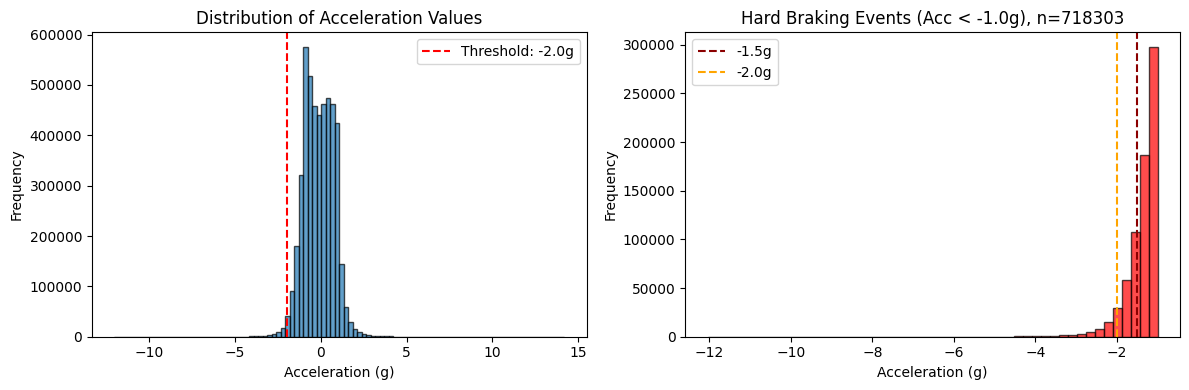

In [9]:
# visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# full distribution
axes[0].hist(acc_values, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(x=-2.0, color='red', linestyle='--', label='Threshold: -2.0g')
axes[0].set_xlabel('Acceleration (g)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Acceleration Values')
axes[0].legend()

# zoomed into braking events
braking_events = acc_values[acc_values < -1.0]
axes[1].hist(braking_events, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1].axvline(x=-1.5, color='darkred', linestyle='--', label='-1.5g')
axes[1].axvline(x=-2.0, color='orange', linestyle='--', label='-2.0g')
axes[1].set_xlabel('Acceleration (g)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Hard Braking Events (Acc < -1.0g), n={len(braking_events)}')
axes[1].legend()

plt.tight_layout()
plt.show()

**Threshold Selection** 


Based on the analysis, I choose **-2.0g** as my braking threshold. This captures approximately 1% of data points (the 1st percentile), representing genuinely sudden deceleration events rather than normal slowing down. The -1.5g threshold would capture about 4% of events, which includes too much routine deceleration.

## Part 4: Define the ABM Parameters

Now I set up the parameters that control my model.

In [ ]:
#ABM Parameters
BRAKING_THRESHOLD = -2.0  # acceleration below this = sudden braking event
P_TRANSITION = 0.3        # probability of transitioning to worse state when braking

print(" ABM params ")
print(f"Braking threshold: {BRAKING_THRESHOLD}g")
print(f"Transition probability: {P_TRANSITION}")

=== ABM Parameters ===
Braking threshold: -2.0g
Transition probability: 0.3


## Part 5: Main ABM loop (the sim function)

This is the core of the ABM. For each trip, the cyclist (agent) moves through their recorded path. At each timestep:
1. Check if a braking event occurred (acceleration < threshold)
2. If yes, potentially transition to a worse safety state
3. Record the state and location

In [11]:
def simulate_trip(trip_df, braking_threshold, p_transition, seed=None):
    """
    Simulate one cyclist trip through the ABM.
    
    Parameters:
  
    trip_df : df with columns lon, lat, acc_y
    braking_threshold : fl, acceleration below this = braking event
    p_transition : fl, P of state transition when braking
    seed 
    
    Returns:
 
    dict with sim results
    """
    if seed is not None:
        np.random.seed(seed)
    
    # initialize agent state
    state = SAFE
    braking_count = 0
    
    # track history for visualization
    history = {
        'states': [],
        'lons': [],
        'lats': [],
        'braking': []
    }
    
    # track locations where state transitions happened
    transition_locations = []
    
    # main simulation loop
    for idx, row in trip_df.iterrows():
        
        acc = row['acc_y']
        lon = row['lon']
        lat = row['lat']
        
        # check for braking event
        is_braking = False
        if pd.notna(acc) and acc < braking_threshold:
            is_braking = True
            braking_count += 1
            
            # apply state transition rule
            if state < UNSAFE:
                if np.random.random() < p_transition:
                    old_state = state
                    state = state + 1
                    transition_locations.append({
                        'lon': lon,
                        'lat': lat,
                        'from_state': old_state,
                        'to_state': state
                    })
        
        # record history
        history['states'].append(state)
        history['lons'].append(lon)
        history['lats'].append(lat)
        history['braking'].append(is_braking)
    
    return {
        'final_state': state,
        'braking_count': braking_count,
        'history': history,
        'transition_locations': transition_locations,
        'trip_id': trip_df['trip_id'].iloc[0] if 'trip_id' in trip_df.columns else 'unknown'
    }

## Part 6: Running the Simulation

Now I run the ABM on all trips and collect results

In [13]:
#run sim on all trips
np.random.seed(10)

results = []
for i, trip_df in enumerate(trips):
    result = simulate_trip(trip_df, BRAKING_THRESHOLD, P_TRANSITION)
    results.append(result)
    
    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(trips)} trips")

print(f"\nSimulation complete! Processed {len(results)} trips.")

Processed 20/110 trips
Processed 40/110 trips
Processed 60/110 trips
Processed 80/110 trips
Processed 100/110 trips

Simulation complete! Processed 110 trips.


In [ ]:
# summarize final states
final_states = [r['final_state'] for r in results]

n_safe = sum(1 for s in final_states if s == SAFE)
n_at_risk = sum(1 for s in final_states if s == AT_RISK)
n_unsafe = sum(1 for s in final_states if s == UNSAFE)

print(" Final State Distribution ")
print(f"SAFE: {n_safe} trips ({100*n_safe/len(results):.1f}%)")
print(f"AT_RISK: {n_at_risk} trips ({100*n_at_risk/len(results):.1f}%)")
print(f"UNSAFE: {n_unsafe} trips ({100*n_unsafe/len(results):.1f}%)")

=== Final State Distribution ===
SAFE: 0 trips (0.0%)
AT_RISK: 1 trips (0.9%)
UNSAFE: 109 trips (99.1%)


In [17]:
# look at braking event counts
braking_counts = [r['braking_count'] for r in results]

print(" Braking Events per Trip ")
print(f"Min: {min(braking_counts)}")
print(f"Max: {max(braking_counts)}")
print(f"Mean: {np.mean(braking_counts):.1f}")
print(f"Median: {np.median(braking_counts):.1f}")

 Braking Events per Trip 
Min: 3
Max: 2633
Mean: 448.2
Median: 259.0


## Part 7: Visualization of Results

Now i create visuals to understand the model behavior

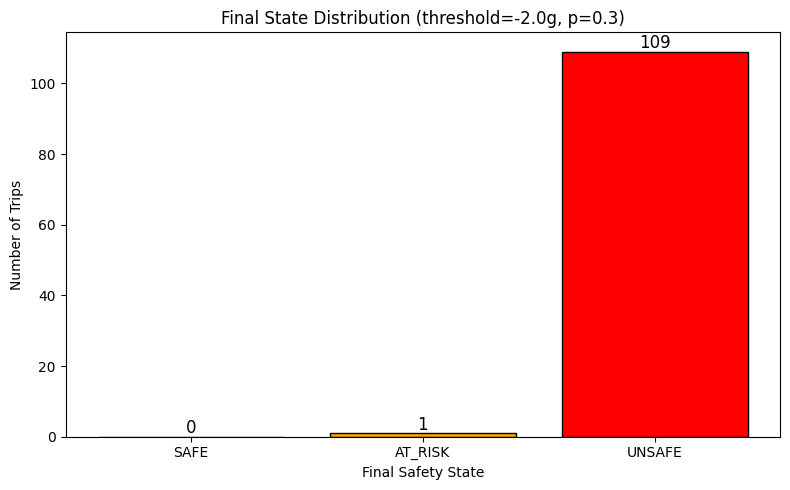

In [18]:
#Plot 1: Final state distribution
plt.figure(figsize=(8, 5))

states = ['SAFE', 'AT_RISK', 'UNSAFE']
counts = [n_safe, n_at_risk, n_unsafe]
colors = ['green', 'orange', 'red']

plt.bar(states, counts, color=colors, edgecolor='black')
plt.xlabel('Final Safety State')
plt.ylabel('Number of Trips')
plt.title(f'Final State Distribution (threshold={BRAKING_THRESHOLD}g, p={P_TRANSITION})')

for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

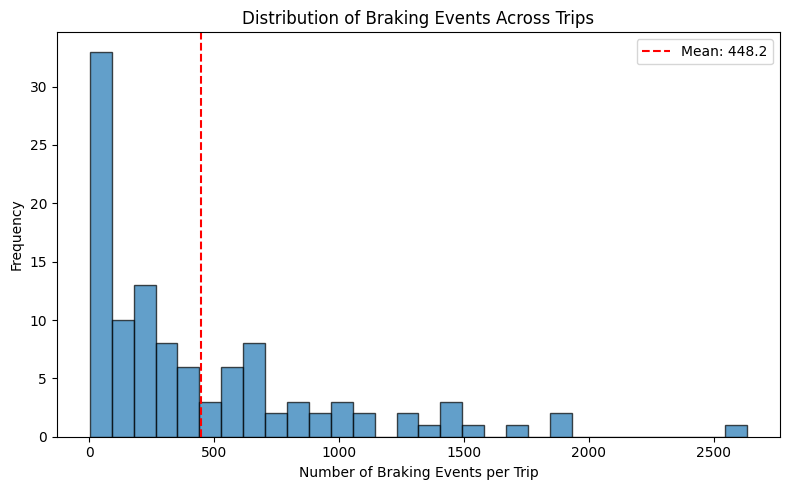

In [19]:
# Plot 2: Braking events histogram
plt.figure(figsize=(8, 5))

plt.hist(braking_counts, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(braking_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(braking_counts):.1f}')
plt.xlabel('Number of Braking Events per Trip')
plt.ylabel('Frequency')
plt.title('Distribution of Braking Events Across Trips')
plt.legend()
plt.tight_layout()
plt.show()

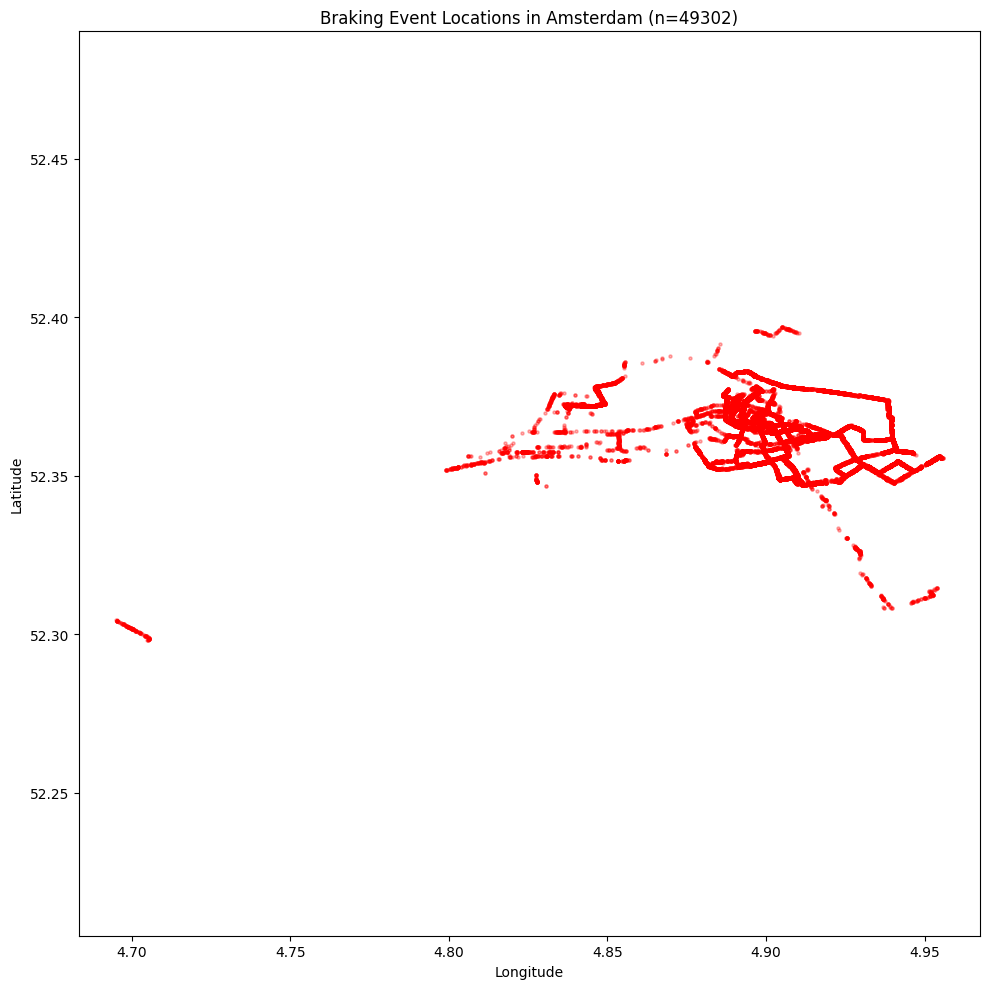

In [20]:
# Plot 3: Map of all braking event locations
plt.figure(figsize=(10, 10))

braking_lons = []
braking_lats = []

for result in results:
    history = result['history']
    for i, is_braking in enumerate(history['braking']):
        if is_braking:
            braking_lons.append(history['lons'][i])
            braking_lats.append(history['lats'][i])

plt.scatter(braking_lons, braking_lats, c='red', alpha=0.3, s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Braking Event Locations in Amsterdam (n={len(braking_lons)})')
plt.axis('equal')
plt.tight_layout()
plt.show()

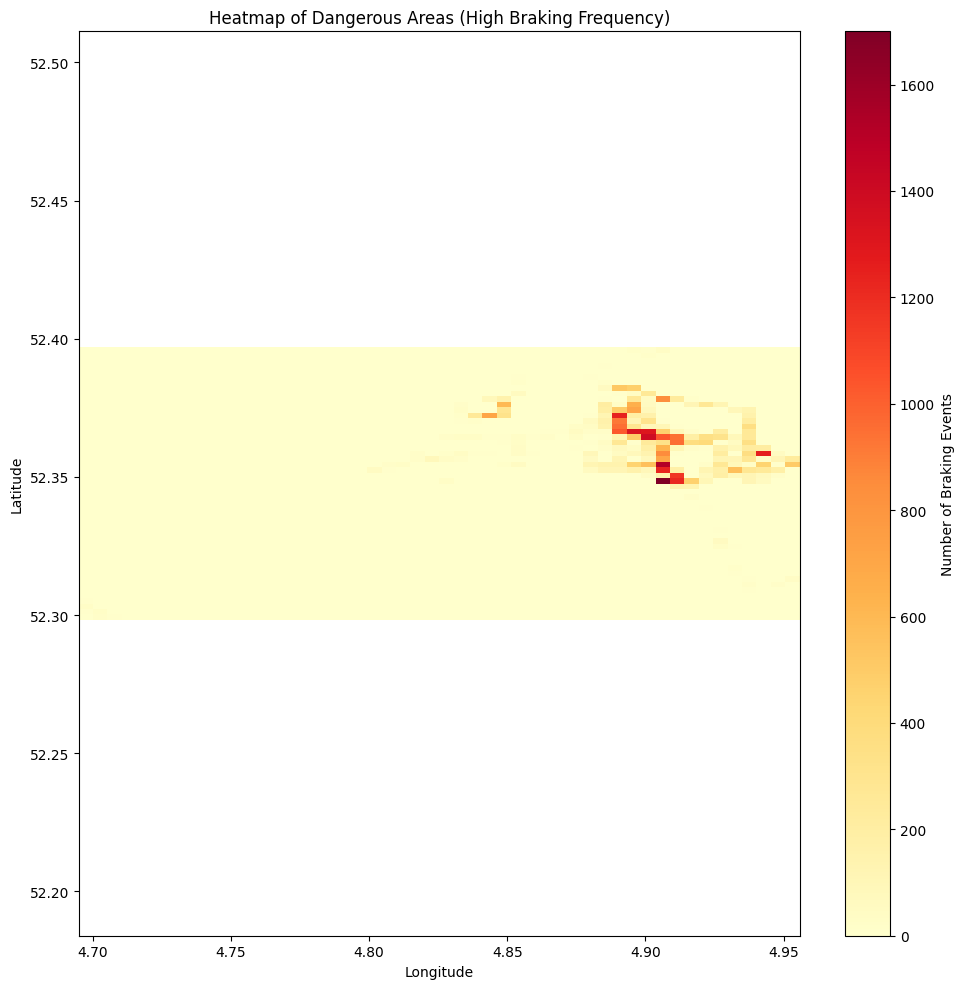

In [21]:
# Plot 4: Heatmap of braking events (dangerous areas)
plt.figure(figsize=(10, 10))

plt.hist2d(braking_lons, braking_lats, bins=50, cmap='YlOrRd')
plt.colorbar(label='Number of Braking Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Dangerous Areas (High Braking Frequency)')
plt.axis('equal')
plt.tight_layout()
plt.show()

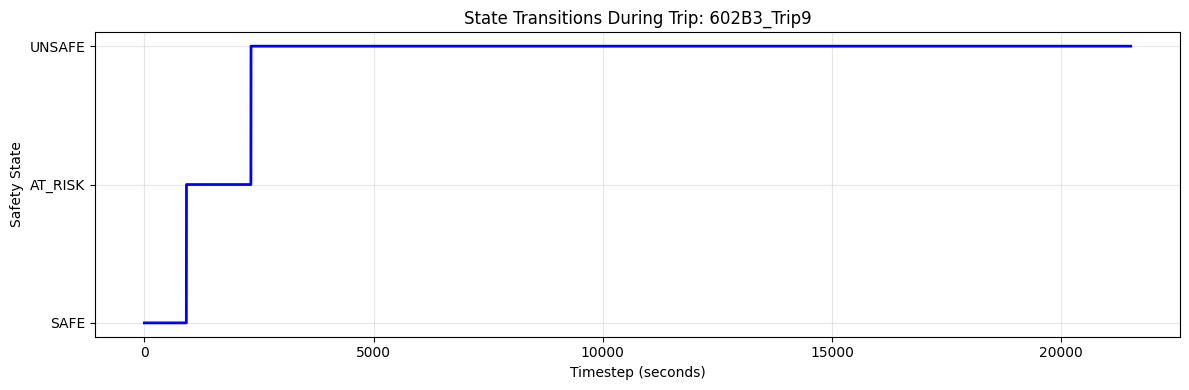

In [22]:
# Plot 5: State transitions over time for a single example trip
unsafe_trips = [r for r in results if r['final_state'] == UNSAFE]

if unsafe_trips:
    example = unsafe_trips[0]
    
    plt.figure(figsize=(12, 4))
    
    states_over_time = example['history']['states']
    timesteps = range(len(states_over_time))
    
    plt.plot(timesteps, states_over_time, 'b-', linewidth=2)
    plt.yticks([0, 1, 2], ['SAFE', 'AT_RISK', 'UNSAFE'])
    plt.xlabel('Timestep (seconds)')
    plt.ylabel('Safety State')
    plt.title(f"State Transitions During Trip: {example['trip_id']}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No trips ended in UNSAFE state with current parameters.")

## Part 8: Interpretation of Dynamics

### What do the results tell me?

**Final State Distribution**
With the default parameters (threshold=-2.0g, p=0.3), almost all trips (99%) end in the UNSAFE state. This occurs because even though I'm only capturing the top 1% most severe braking events, the average trip still contains around 450 such events. With a 30% transition probability per event, cyclists quickly accumulate enough risk to reach the UNSAFE state.

**Braking Events**
On average, cyclists experience approximately 448 braking events per trip, though this varies widely (from 3 to over 2,600). The distribution is right-skewed, with most trips having 50-300 events but some longer trips accumulating many more. This variation reflects differences in trip length and route choice.

**Spatial Patterns**
The heatmap reveals clear hotspots where braking events cluster, particularly in central Amsterdam. These areas correspond to locations with dense intersections, canal bridges, high pedestrian traffic, and tram crossings. When compared with speed data from the same trips, areas with high braking frequency align with areas where cyclists travel slowly or stop frequently — validating that the model captures real infrastructure challenges.

**Why does this pattern emerge?**
The cumulative, no-recovery state transition model means that risk accumulates over time. Longer trips thru busy central areas experience more braking events and are therefore more likely to end in an unsafe state. The probabilistic transition adds realistic stochasticity — not every braking event leads to danger, but over many events, the probability of transitioning becomes near-certain.

## Part 9: Sensitivity Analysis

I vary the key parameters to see how the system responds. This helps identify tipping points and test model robustness

In [23]:
def run_experiment_fast(trips, braking_threshold, p_transition, seed=42):
    """
    Fast version of experiment runner using vectorized operations. so its doesnt take 10 mins
    """
    np.random.seed(seed)
    
    final_states = []
    
    for trip_df in trips:
        # count braking events (vectorized)
        braking_events = (trip_df['acc_y'] < braking_threshold).sum()
        
        # simulate state transitions
        state = SAFE
        for _ in range(braking_events):
            if state < UNSAFE and np.random.random() < p_transition:
                state += 1
        
        final_states.append(state)
    
    n_safe = sum(1 for s in final_states if s == SAFE)
    n_at_risk = sum(1 for s in final_states if s == AT_RISK)
    n_unsafe = sum(1 for s in final_states if s == UNSAFE)
    
    return {
        'pct_safe': 100 * n_safe / len(final_states),
        'pct_at_risk': 100 * n_at_risk / len(final_states),
        'pct_unsafe': 100 * n_unsafe / len(final_states)
    }

In [25]:
# Sensitivity Analysis 1: Vary braking threshold
print(" Sensitivity Analysis: Braking Threshold ")

thresholds = [-1.0, -1.25, -1.5, -1.75, -2.0, -2.5, -3.0]
threshold_results = []

for thresh in thresholds:
    result = run_experiment_fast(trips, thresh, P_TRANSITION)
    threshold_results.append(result)
    print(f"Threshold {thresh}g: Safe={result['pct_safe']:.1f}%, "
          f"At Risk={result['pct_at_risk']:.1f}%, Unsafe={result['pct_unsafe']:.1f}%")

 Sensitivity Analysis: Braking Threshold 
Threshold -1.0g: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
Threshold -1.25g: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
Threshold -1.5g: Safe=0.0%, At Risk=0.9%, Unsafe=99.1%
Threshold -1.75g: Safe=0.0%, At Risk=0.9%, Unsafe=99.1%
Threshold -2.0g: Safe=0.9%, At Risk=0.9%, Unsafe=98.2%
Threshold -2.5g: Safe=0.0%, At Risk=6.4%, Unsafe=93.6%
Threshold -3.0g: Safe=6.4%, At Risk=3.6%, Unsafe=90.0%


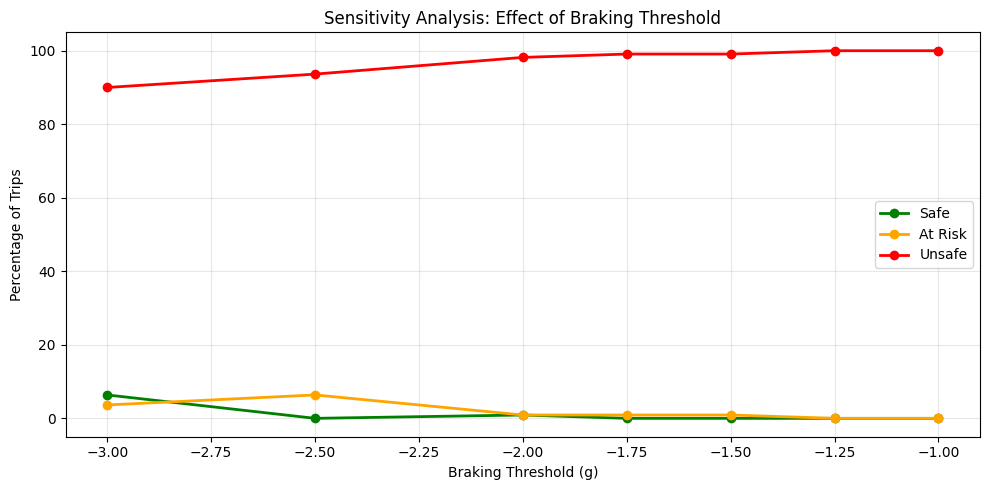

In [26]:
# Plot threshold sensitivity
plt.figure(figsize=(10, 5))

pct_safe = [r['pct_safe'] for r in threshold_results]
pct_at_risk = [r['pct_at_risk'] for r in threshold_results]
pct_unsafe = [r['pct_unsafe'] for r in threshold_results]

plt.plot(thresholds, pct_safe, 'g-o', label='Safe', linewidth=2)
plt.plot(thresholds, pct_at_risk, 'orange', marker='o', label='At Risk', linewidth=2)
plt.plot(thresholds, pct_unsafe, 'r-o', label='Unsafe', linewidth=2)

plt.xlabel('Braking Threshold (g)')
plt.ylabel('Percentage of Trips')
plt.title('Sensitivity Analysis: Effect of Braking Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Sensitivity Analysis 2: Vary transition probability (standard range)
print("=== Sensitivity Analysis: Transition Probability ===")

probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
prob_results = []

for prob in probabilities:
    result = run_experiment_fast(trips, BRAKING_THRESHOLD, prob)
    prob_results.append(result)
    print(f"p={prob}: Safe={result['pct_safe']:.1f}%, "
          f"At Risk={result['pct_at_risk']:.1f}%, Unsafe={result['pct_unsafe']:.1f}%")

=== Sensitivity Analysis: Transition Probability ===
p=0.1: Safe=3.6%, At Risk=0.9%, Unsafe=95.5%
p=0.2: Safe=0.9%, At Risk=0.9%, Unsafe=98.2%
p=0.3: Safe=0.9%, At Risk=0.9%, Unsafe=98.2%
p=0.4: Safe=0.0%, At Risk=0.9%, Unsafe=99.1%
p=0.5: Safe=0.0%, At Risk=0.9%, Unsafe=99.1%
p=0.6: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
p=0.7: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
p=0.8: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
p=0.9: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%
p=1.0: Safe=0.0%, At Risk=0.0%, Unsafe=100.0%


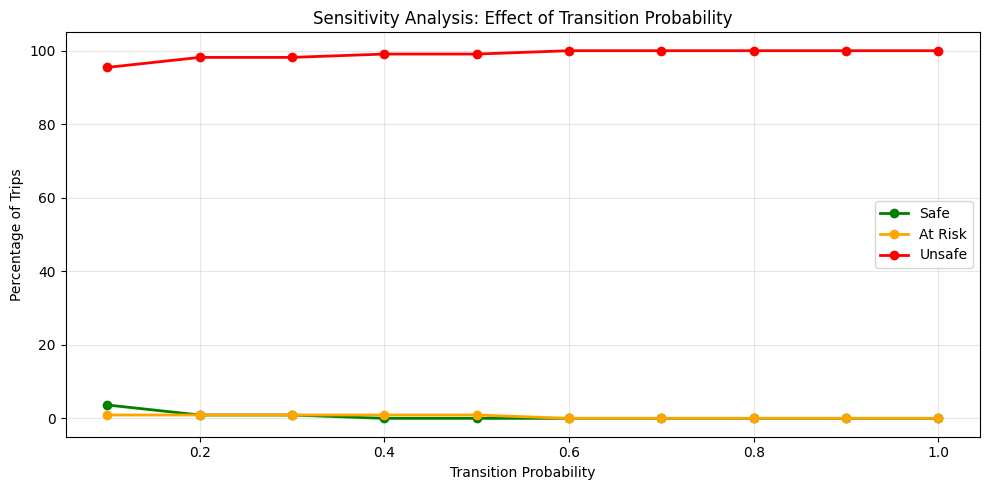

In [28]:
# Plot probability sensitivity (standard range)
plt.figure(figsize=(10, 5))

pct_safe = [r['pct_safe'] for r in prob_results]
pct_at_risk = [r['pct_at_risk'] for r in prob_results]
pct_unsafe = [r['pct_unsafe'] for r in prob_results]

plt.plot(probabilities, pct_safe, 'g-o', label='Safe', linewidth=2)
plt.plot(probabilities, pct_at_risk, 'orange', marker='o', label='At Risk', linewidth=2)
plt.plot(probabilities, pct_unsafe, 'r-o', label='Unsafe', linewidth=2)

plt.xlabel('Transition Probability')
plt.ylabel('Percentage of Trips')
plt.title('Sensitivity Analysis: Effect of Transition Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Sensitivity Analysis 3: Vary transition probability (LOW range to find tipping point)
print("=== Sensitivity Analysis: Transition Probability (Low Range) ===")

probabilities_low = [0.001, 0.002, 0.003, 0.005, 0.007, 0.01, 0.02, 0.03, 0.05]
prob_results_low = []

for prob in probabilities_low:
    result = run_experiment_fast(trips, BRAKING_THRESHOLD, prob)
    prob_results_low.append(result)
    print(f"p={prob}: Safe={result['pct_safe']:.1f}%, "
          f"At Risk={result['pct_at_risk']:.1f}%, Unsafe={result['pct_unsafe']:.1f}%")

=== Sensitivity Analysis: Transition Probability (Low Range) ===
p=0.001: Safe=72.7%, At Risk=13.6%, Unsafe=13.6%
p=0.002: Safe=60.0%, At Risk=17.3%, Unsafe=22.7%
p=0.003: Safe=53.6%, At Risk=20.9%, Unsafe=25.5%
p=0.005: Safe=40.0%, At Risk=20.9%, Unsafe=39.1%
p=0.007: Safe=34.5%, At Risk=20.9%, Unsafe=44.5%
p=0.01: Safe=28.2%, At Risk=13.6%, Unsafe=58.2%
p=0.02: Safe=22.7%, At Risk=9.1%, Unsafe=68.2%
p=0.03: Safe=13.6%, At Risk=12.7%, Unsafe=73.6%
p=0.05: Safe=6.4%, At Risk=9.1%, Unsafe=84.5%


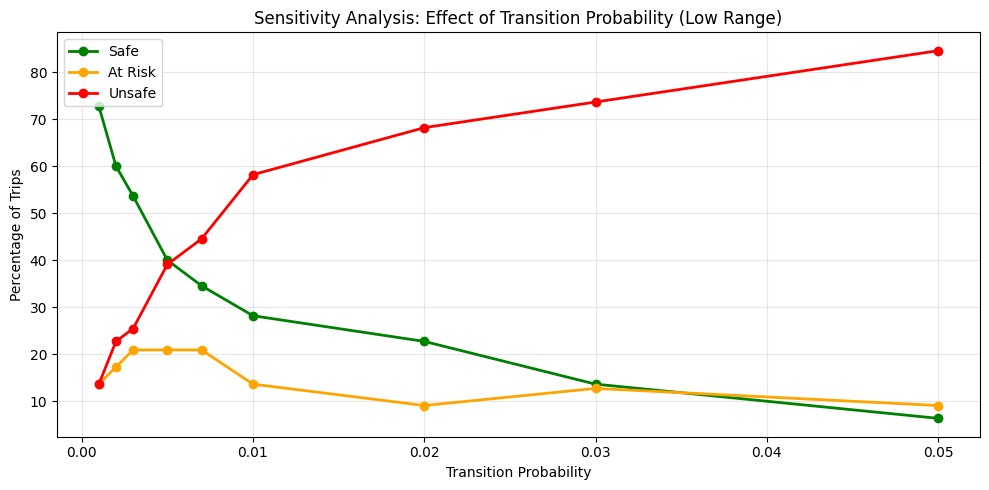

In [30]:
# Plot probability sensitivity (low range - shows tipping point)
plt.figure(figsize=(10, 5))

pct_safe = [r['pct_safe'] for r in prob_results_low]
pct_at_risk = [r['pct_at_risk'] for r in prob_results_low]
pct_unsafe = [r['pct_unsafe'] for r in prob_results_low]

plt.plot(probabilities_low, pct_safe, 'g-o', label='Safe', linewidth=2)
plt.plot(probabilities_low, pct_at_risk, 'orange', marker='o', label='At Risk', linewidth=2)
plt.plot(probabilities_low, pct_unsafe, 'r-o', label='Unsafe', linewidth=2)

plt.xlabel('Transition Probability')
plt.ylabel('Percentage of Trips')
plt.title('Sensitivity Analysis: Effect of Transition Probability (Low Range)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Sensitivity Analysis Interpretation

**Braking threshold**
Varying the threshold from -1.0g to -3.0g has limited effect on outcomes. Even at the strictest threshold (-3.0g), 90% of trips still end in UNSAFE. This is because even rare, severe braking events occur frequently enough over a typical trip to push cyclists into the unsafe state. The model **saturates** because the average trip has hundreds of braking events regardless of threshold

**Transition P (standard range)**
At Ps from 0.1 to 1.0, the model remains saturated — nearly all trips end UNSAFE. This range is too high given the number of braking events per trip. Even at p=0.1, with ~450 braking events, the expected number of transitions is 45, far exceeding the 2 needed to reach UNSAFE.

**Transition P (low range) — the tipping point**
The true tipping point emerges at very low Ps. At p≈0.005, the Safe and Unsafe curves cross at roughly 40% each, representing a balanced system. Below this threshold (p<0.005), most trips remain safe; above it, most become unsafe. This is the critical finding: the transition P must be extremely low (0.1-0.5% per braking event) to produce meaningful variation in outcomes

**Key insight**
The model reveals that the *severity* of braking events (captured by p) matters more than their *frequency* (captured by threshold) in determining trip safety. With hundreds of braking events per trip, even small per-event risk probabilities compound into high cumulative risk.

## Part 10: Conclusions

### Summary

This ABM simulates cyclist safety in Amsterdam using real sensor data from 110 cycling trips. The model treats each trip as an agent moving through the city, accumulating risk through sudden braking events detected from accelerometer data.

**Key findings**

1. **Dangerous hotspots exist** The spatial analysis reveals that braking events cluster in central Amsterdam, particularly around areas with dense intersections, canal bridges, and high pedestrian traffic. This pattern validates against independent speed data showing the same areas have low cycling speeds

2. **The system has a clear tipping point** The model exhibits a critical threshold at transition P p≈0.005. Below this value, most trips complete safely; above it, cumulative risk causes most trips to end in an unsafe state. This tipping point behavior is characteristic of threshold-based complex systems

3. **Frequency vs severity** With an average of 448 braking events per trip, the frequency of events is high enough that even small per-event transition Ps compound into significant cumulative risk. The braking threshold (event detection) matters less than the transition P (event severity) in determining outcomes

4. **Cumulative risk matters** The no-recovery model assumption means that longer trips through busy areas inevitably accumulate more risk, reflecting real-world exposure dynamics where time spent cycling correlates with incident P

### Limitations

- The model treats all braking events as equivalent, not distinguishing routine intersection stops from emergency braking to avoid collisions
- No agent-to-agent interaction — cyclists don't influence each other's behavior or create congestion effects
- The three-state model (Safe → At Risk → Unsafe) is a simplification; real safety is a continuous spectrum
- Sensor placement and calibration may affect acceleration measurements across different bikes

### Future Extensions

- Incorporate road surface data to test whether certain materials correlate with more braking events (will it be possible considering the wvk_id issue?)
- Add time-of-day effects to compare rush hour versus quiet periods (very possible)
- Model multiple cyclists simultaneously with interaction effects (very interesting addition, programatically hard and perhaps cannot be extracted from the sensor data?)
- Implement a recovery mechanism where safe stretches of road allow cyclists to return to lower risk states (very easy standpoint but needs a proper discussion on intiail params set up & usefullness of recovery period in general for the bike setting)
- Validate against actual incident data to calibrate the transition probability to real-world risk levels (seems possible considering we have the dataset on our hands (if Juriaan will provide source code and that the dataset was taken from a good source with proper cleaning steps) it would be internal ABM calibration, no ml required so the low amount of datapoints can be fine)


## ABM idea = possible!

**HOWEVER IT WILL ONLY BE POSSIBLE TO USE AS ANY FINAL SUBMISSION IF EACH GROUP MEMBER SUBSTANTIALLY CONTRIBUTES ON AT LEAST ONE USEFUL IMPLEMENTATION POINT**